# Neural Network Training

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Importing 2 seasons of NBA data (2022-23, 2023-24)

In [57]:
season_22 = pd.read_csv('../data_generation/output_data/2022-23_data.csv')
season_23 = pd.read_csv('../data_generation/output_data/2023-24_data.csv')

combined_seasons = pd.concat([season_22, season_23], ignore_index = True)
combined_seasons = combined_seasons.drop_duplicates()
combined_seasons = combined_seasons.reset_index(drop=True)

# print(combined_seasons.info())
# print(combined_seasons.describe())

## Prepare features and target value

In [63]:
input = combined_seasons.drop(columns=['PTS'])
target = combined_seasons['PTS']

spearman_corr = pd.read_csv('../data_generation/output_data/spearman_corr_features.csv')

selected_features = spearman_corr['Feature'].tolist()

# Ensure no mismatching features
existing_features = [feature for feature in selected_features if feature in input.columns]

input = combined_seasons[existing_features]
input = input.dropna(axis=1)
print(input.info()) # 4920 rows, 66 columns
# print(input['personId_my_player_4'])

# Split into train and test set
input_train, input_test, target_train, target_test = train_test_split(input, target, test_size=0.2, random_state=0)

# Scaling features
scaler = StandardScaler()
input_train = scaler.fit_transform(input_train)
input_test = scaler.transform(input_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 61 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   fieldGoalPercentage_my_player_1              4920 non-null   float64
 1   uncontestedFieldGoalsPercentage_my_player_1  4920 non-null   float64
 2   fieldGoalPercentage_my_player_4              4920 non-null   float64
 3   fieldGoalPercentage_my_player_3              4920 non-null   float64
 4   fieldGoalPercentage_my_player_2              4920 non-null   float64
 5   uncontestedFieldGoalsMade_my_player_1        4920 non-null   float64
 6   fieldGoalPercentage_my_player_6              4920 non-null   float64
 7   fieldGoalPercentage_my_player_5              4920 non-null   float64
 8   uncontestedFieldGoalsPercentage_my_player_2  4920 non-null   float64
 9   uncontestedFieldGoalsPercentage_my_player_6  4920 non-null   float64
 10  

## Define the model

In [64]:
# Initialize sequential model 
model = Sequential([
    Input(shape=(input_train.shape[1],)), # define input shape
    Dense(64, activation='relu'), # first hidden layer with 64 units
    Dropout(0.2), 
    Dense(32, activation='relu'), # second hidden layer with 32 units
    Dense(1) # Output layer with target (PTS)
])

# Compile the model 
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(input_train, target_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12186.2607 - mae: 109.5542 - val_loss: 6800.2607 - val_mae: 81.2056
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 4376.3296 - mae: 61.3832 - val_loss: 558.8027 - val_mae: 19.0296
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 663.6208 - mae: 20.7620 - val_loss: 459.3440 - val_mae: 17.3077
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 555.1067 - mae: 18.8376 - val_loss: 411.4325 - val_mae: 16.3451
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 503.6313 - mae: 17.6898 - val_loss: 377.3927 - val_mae: 15.7818
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 452.2355 - mae: 17.0131 - val_loss: 353.8326 - val_mae: 15.2668
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 428.2684 - mae: 16.4341 - val_loss: 330.0509 - val_mae: 14.7498
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 409.8247 - mae: 16.1161 - val_loss: 314.1110 - val_mae: 14.4594
Epoch 9/5

## Visualize History

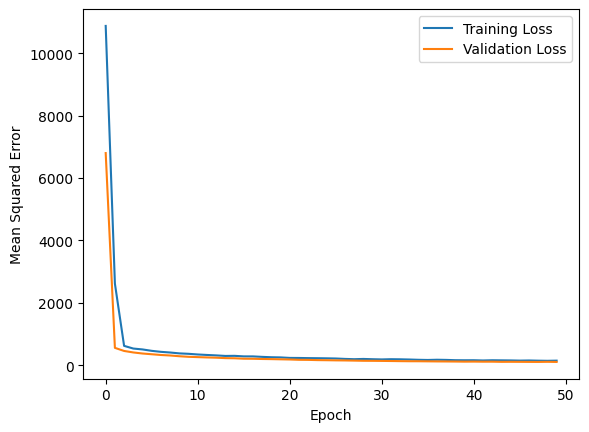

In [65]:
# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

## Evaluation and Sample Target Prediction

In [67]:
# Evaluate model on test data
test_loss, test_mae = model.evaluate(input_test, target_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Target prediction
sample_predictions = model.predict(input_test)
print("Sample Predictions (PTS):", sample_predictions[:10].flatten())
print("Actual Vales (PTS):", target_test[:10].values)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 97.0986 - mae: 7.7968
Test Loss (MSE): 98.86361694335938
Test MAE: 7.885351657867432
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step
Sample Predictions (PTS): [124.09716  110.59908  134.36588  120.927025 116.871605 100.97604
 123.77379  111.778435 119.421005 117.24224 ]
Actual Vales (PTS): [127 125 122 122 112 106 134 107 116 127]
